# Supenovae IA MCMC
---

Using data from Type Ia supernovae, key cosmological parameters such as the Hubble constant, matter density and vacuum energy density can be inferred using Bayesian inference methods. A variety of techniques can be applied, however in this instance Markov Chain Monte Carlo (MCMC) will be applied, optimised and examined; with the results it provides being discussed.

---

In [1]:
import numpy as np
import matplotlib as plt
import seaborn as sb
import pandas as pd
import corner

In [2]:
#read in data
data_df = pd.read_csv("Pantheon+SH0ES.dat", sep=' ')
cov_df = pd.read_csv("Pantheon+SH0ES_STAT+SYS.cov.txt", sep=' ')

In [3]:
#reshape and structure the covariance matrix
cov_array = cov_df.iloc[:,0].values #convert to array
N = int(np.sqrt(len(cov_array))) #find len
cov_matrix = cov_array.reshape(N, N) #reshape to len
cov_matrix = (cov_matrix + cov_matrix.T) / 2 #make symmetrical (as stored block wise)

### Discarding Supernovae
---

Supernovae with z < 0.01 can be discarded, this is to ensure the analysis focuses on the cosmological aspects of the dataset. Including data with peculiar velocities could potentially distort the signal.

In [4]:
mdata_df = data_df[data_df['zHD'] >= 0.01] #filter dataset

kept_indices = mdata_df.index #find indices of kept data

mcov_matrix = cov_matrix[np.ix_(kept_indices, kept_indices)] #filter same rows/columns from matrix

### MCMC
---

Due to its capability to handle complex datasets with a high dimensional probablility distributions and include prior knowledgem, MCMC is a typical tool used in cosmology studies. There are other potential methods, such as simulator based inference, the advantage of which being it isn't reliant on a known likelihood. In this instance MCMC is likely a more reliable and commonly used method for this type of problem.

Metropolis-Hastings has been chosen as the sampling method due to it being well suited for complex, non-linear, multi dimensional distributions. Not only can it handle these distributions effectively, it also does so very efficiently.

In [5]:
def eta(a, omega_m): #returns value of eta for a and omega_m
    s = np.cbrt((1 - omega_m) / omega_m) #value of s
    return (2 * np.sqrt(s**3 + 1)) * (((1 / a**4) - (0.1540 * s / a**3) + (0.4304 * s**2 / a**2) + (0.19097 * s**3 / a) + (0.066941 * s**4))**(-1/8))

def mu_calc(z, h, omega_m):
    c = 299792.458 #speed of light
    H0 = 100 #* h #hubble constant

    #calculate D_L_star using U.-L. Pen's formula
    D_L_star = (c / H0) * (1 + z) * (eta(1, omega_m) - eta(1 / (1 + z), omega_m))

    #calculate the theoretical distance modulus
    mu_th = 25 - 5 * np.log10(h) + 5 * np.log10(D_L_star)
    return mu_th

In [6]:
import numpy.linalg as la

def likelihood(h, omega_m, data):
    n = len(mdata_df) #finds length of data
    mu_diff = np.zeros(n) #inits diff array

    for i in range(n): #iterate over each row
        z = mdata_df.iloc[i]['zHD'] #finds z
        mu_obs = mdata_df.iloc[i]['MU_SH0ES'] #finds mu observed
        mu_th = mu_calc(z,h,omega_m) #calcs mu theoretical
        mu_diff[i] = mu_obs - mu_th #finds the difference
        #print(mu_obs,mu_th,mu_diff[i])

    inv_cov = la.inv(mcov_matrix) #takes inverse of the matrix
    chi_squared = mu_diff @ inv_cov @ mu_diff #chi squared statistic
    NLL = -chi_squared/2 #calcs negative long likelihood
    #L = np.exp(-chi_squared / 2)
    
    return NLL

In [7]:
def metropolis_hastings(data, initial_parameters, n_iterations, proposal_width, burn_in):
    h_current, omega_m_current = initial_parameters
    samples = []
    accepted = 0
    
    for i in range(n_iterations):
        #propose new candidate parameters using a top-hat distribution
        h_proposal = np.random.uniform(h_current - proposal_width, h_current + proposal_width)
        omega_m_proposal = np.random.uniform(omega_m_current - proposal_width, omega_m_current + proposal_width)

        #check if proposed parameters are within the valid range
        if 0 <= h_proposal <= 1 and 0 <= omega_m_proposal <= 1:
            p_current = likelihood(h_current, omega_m_current, data)
            p_proposal = likelihood(h_proposal, omega_m_proposal, data)
            
            #calculate acceptance probability based on NLL
            p_delta = p_proposal - p_current
            p_accept = np.exp(p_delta)
                            
            #accept or reject the new parameters
            if np.random.rand() < p_accept:
                h_current, omega_m_current = h_proposal, omega_m_proposal
                accepted += 1
        
        #collect samples after the burn-in period
        if i >= burn_in:
            samples.append([h_current, omega_m_current])
            
    acceptance_rate = accepted / n_iterations #calcs acceptance rate
    
    return np.array(samples), acceptance_rate

### Small vs Large Width
---

When it comes to a proposal width, it's important to find the right balance between too large and too little. This ensures that the algorithm effectively explores the parameter space whilst maintaing a reasonable accpetance rate. Similarly it can improve efficiency and accuracy, allowing the chain to converge on the target distribution quickly and accurately reflecting the characteristics of the distribution.

In [8]:
#[0.678, 0.315]

initial_parameters = [0.5, 0.5]  #neutral initial guesses
n_iterations = 1000

In [9]:
small_proposal_width = 0.02

small_width_samples, _ = metropolis_hastings(mdata_df, initial_parameters, n_iterations, small_proposal_width,0)

/tmp/ipykernel_37328/654286778.py:18: RuntimeWarning: overflow encountered in exp
  p_accept = np.exp(p_delta)


With the smaller proposal width, the algorithm takes a significant amount of steps to coverge. This is due to it taking many tiny steps and therefore taking longer to explore the parameter space.

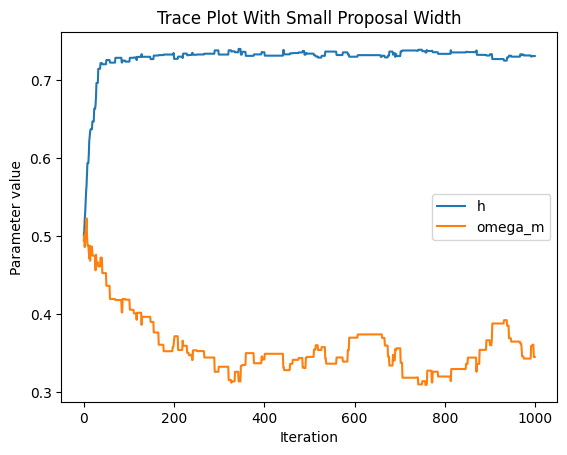

In [10]:
import matplotlib.pyplot as plt

#plotting the trace for small proposal width
plt.plot(small_width_samples[:, 0], label='h')
plt.plot(small_width_samples[:, 1], label='omega_m')
plt.title('Trace Plot With Small Proposal Width')
plt.xlabel('Iteration')
plt.ylabel('Parameter value')
plt.legend()

In [11]:
large_proposal_width = 0.2

large_width_samples, _ = metropolis_hastings(mdata_df, initial_parameters, n_iterations, large_proposal_width,0)

/tmp/ipykernel_37328/654286778.py:18: RuntimeWarning: overflow encountered in exp
  p_accept = np.exp(p_delta)


With the larger width, the parameter space is explored much more rapidly, however using a larger width can often mean important regions can be "overshot", leading to inaccurate representations of the distribution.

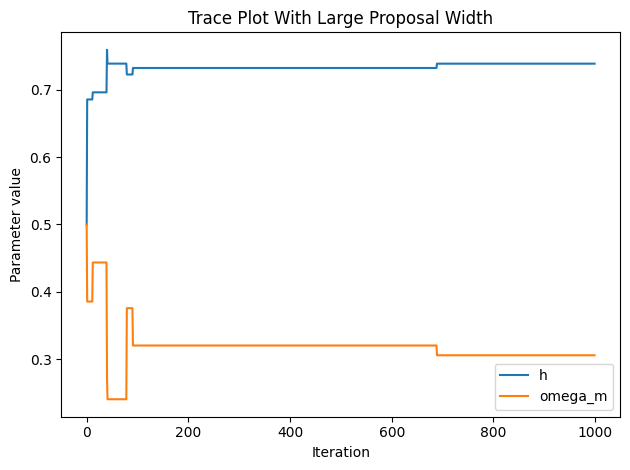

In [12]:
#plotting the trace for large proposal width
plt.plot(large_width_samples[:, 0], label='h')
plt.plot(large_width_samples[:, 1], label='omega_m')
plt.title('Trace Plot With Large Proposal Width')
plt.xlabel('Iteration')
plt.ylabel('Parameter value')
plt.legend()

plt.tight_layout()
plt.show()

It's that the balanced proposal width lies somewhere between the two values.

### Burn-In
---

At the start of a MCMC chain, the values are heavily biased towards the intial values, since the algorithm has not explored much of the parameter space. To counteract this, a burn-in period can be applied. This is often chosen based on the convergence of the model. To illustrate this, a burn-in period is chosen for both of our previous widths.

For the low width model, a higher burn-in of 300 would be required. This also adds to the downsides of too small a width, since it is computationally inefficient to burn 300 samples.

/tmp/ipykernel_37328/654286778.py:18: RuntimeWarning: overflow encountered in exp
  p_accept = np.exp(p_delta)


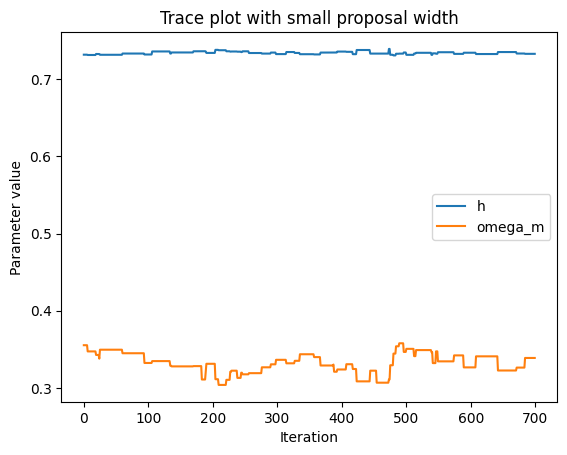

In [13]:
small_width_samples, _ = metropolis_hastings(mdata_df, initial_parameters, n_iterations, small_proposal_width,300)

plt.plot(small_width_samples[:, 0], label='h')
plt.plot(small_width_samples[:, 1], label='omega_m')
plt.title('Trace plot with small proposal width')
plt.xlabel('Iteration')
plt.ylabel('Parameter value')
plt.legend()

For a larger model, a lower burn-in is required due to the algorithm converging much quicker.

/tmp/ipykernel_37328/654286778.py:18: RuntimeWarning: overflow encountered in exp
  p_accept = np.exp(p_delta)


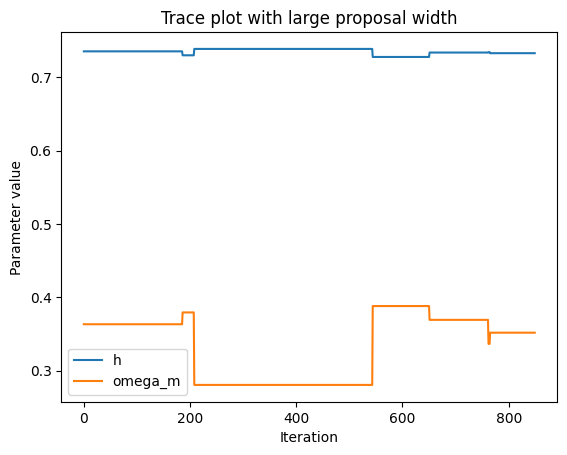

In [14]:
large_width_samples, _ = metropolis_hastings(mdata_df, initial_parameters, n_iterations, large_proposal_width,150)

plt.plot(large_width_samples[:, 0], label='h')
plt.plot(large_width_samples[:, 1], label='omega_m')
plt.title('Trace plot with large proposal width')
plt.xlabel('Iteration')
plt.ylabel('Parameter value')
plt.legend()

### Acceptance Rate
---

It's worth also examining the effect of width on the acceptance rate. As illustrated as the width increases, the acceptance rate decreases. This is due to the algorithm exploring areas of the parameter space that are less probable, and are therefore rejected.

/tmp/ipykernel_37328/654286778.py:18: RuntimeWarning: overflow encountered in exp
  p_accept = np.exp(p_delta)


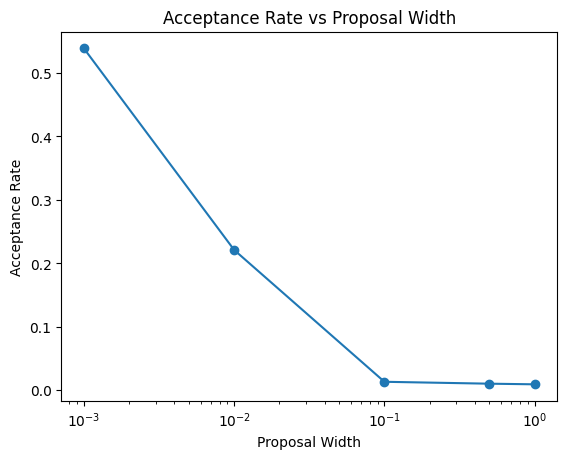

In [15]:
proposal_widths = [0.001, 0.01, 0.1, 0.5, 1]
acceptance_rates = []

#iterates over the array of proposal widths
for width in proposal_widths:
    samples, rate = metropolis_hastings(mdata_df, initial_parameters, 1000, width,200)
    acceptance_rates.append(rate)

#plots acceptance for proposal widths
plt.plot(proposal_widths, acceptance_rates, marker='o')
plt.xscale('log')
plt.xlabel('Proposal Width')
plt.ylabel('Acceptance Rate')
plt.title('Acceptance Rate vs Proposal Width')
plt.show()

### Chosen MCMC Paramaters and Final Metrics
---

For the final width and burn in, 0.1 and 200 were chosen respectively, this provides the perfect balance between convergence and accuracy. The mean values of h and omega are also close to the real values, which suggests the algorithm is effective.

/tmp/ipykernel_37328/654286778.py:18: RuntimeWarning: overflow encountered in exp
  p_accept = np.exp(p_delta)


Mean of h: 0.7340634503544661, Variance of h: 3.6196451636156613e-06
Mean of Omega_m: 0.34261289805778744, Variance of Omega_m: 0.00010331003821267137
Covariance Matrix:
[[ 3.62417538e-06 -1.55358705e-05]
 [-1.55358705e-05  1.03439337e-04]]


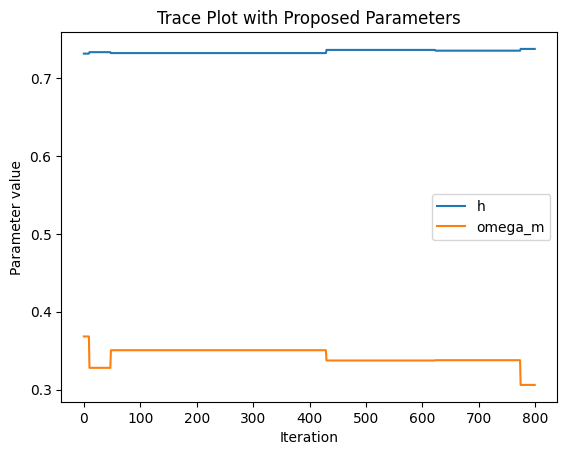

In [16]:
samples, _ = metropolis_hastings(mdata_df, initial_parameters, 1000, 0.1,200)

plt.plot(samples[:, 0], label='h')
plt.plot(samples[:, 1], label='omega_m')
plt.title('Trace Plot with Proposed Parameters')
plt.xlabel('Iteration')
plt.ylabel('Parameter value')
plt.legend()

#compute averages (means)
mean_h = np.mean(samples[:, 0])
mean_omega_m = np.mean(samples[:, 1])

#compute variances
var_h = np.var(samples[:, 0])
var_omega_m = np.var(samples[:, 1])

#compute covariance
cov_matrix = np.cov(samples.T)  # Transpose to get parameters as columns

#print results
print(f"Mean of h: {mean_h}, Variance of h: {var_h}")
print(f"Mean of Omega_m: {mean_omega_m}, Variance of Omega_m: {var_omega_m}")
print("Covariance Matrix:")
print(cov_matrix)

## Non-Flat Universe
---

By using the unsimplified formuli and including omega_v, the algorithm can be generalised to consider the possibility of a closed or open universe.

In [17]:
import scipy.integrate as integrate
import numpy.linalg as la

def mu_calc(z, h, omega_m, omega_v):
    c = 299792.458  #speed of light in km/s
    H0 = 100   #hubble constant in km/s/Mpc
    omega = omega_m + omega_v  #total density parameter

    #define the integrand for the numerical integral
    def integrand(z_prime):
        return 1.0 / np.sqrt(omega_m * (1 + z_prime)**3 + omega_v + (1 - omega) * (1 + z_prime)**2)

    #perform the numerical integral
    integral, _ = integrate.quad(integrand, 0, z)
    
    #curvature_term = np.sqrt(abs(1 - omega))
    
    if omega > 1:  #closed universe
        Sk_r = np.sin(np.sqrt(abs(1 - omega)) * integral)
    elif omega < 1:  #open Universe
        Sk_r = np.sinh(np.sqrt(abs(1 - omega))* integral)
    else:  #flat univers
        Sk_r = integral

    #calculate D_L, including the curvature term
    D_L_star = (c / H0) * (1 + z) * Sk_r / np.sqrt(abs(1 - omega))

    #calculate the theoretical distance modulus
    mu_th = 25 - 5 * np.log10(h) + 5 * np.log10(D_L_star)  # D_L_star in Mpc
    return mu_th


def likelihood(h, omega_m, omega_v, data):
    ####same calculation as before but with omega_v now passed to calculate mu_th
    n = len(data)
    mu_diff = np.zeros(n)

    for i in range(n):
        z = data.iloc[i]['zHD']
        mu_obs = data.iloc[i]['MU_SH0ES']
        mu_th = mu_calc(z, h, omega_m, omega_v)
        mu_diff[i] = mu_obs - mu_th

    inv_cov = la.inv(mcov_matrix)
    chi_squared = mu_diff @ inv_cov @ mu_diff
    NLL = -chi_squared / 2
    
    return NLL

In [37]:
def metropolis_hastings(data, initial_parameters, n_iterations, proposal_width, burn_in):
    h_current, omega_m_current, omega_v_current = initial_parameters
    samples = []
    accepted = 0
    
    for i in range(n_iterations):
        #propose new candidate parameters using a top-hat distribution
        h_proposal = np.random.uniform(h_current - proposal_width, h_current + proposal_width)
        omega_m_proposal = np.random.uniform(omega_m_current - proposal_width, omega_m_current + proposal_width)
        omega_v_proposal = np.random.uniform(omega_v_current - proposal_width, omega_v_current + proposal_width)

        #check if proposed parameters are within the valid range
        if 0 <= h_proposal <= 1 and 0 <= omega_m_proposal <= 1:
            p_current = likelihood(h_current, omega_m_current, omega_v_current, data)
            p_proposal = likelihood(h_proposal, omega_m_proposal, omega_v_proposal, data)
            
            #calculate acceptance probability based on log-likelihood
            p_delta = p_proposal - p_current
            p_accept = np.exp(p_delta)
                            
            #accept or reject the new parameters
            if np.random.rand() < p_accept:
                h_current, omega_m_current, omega_v_current = h_proposal, omega_m_proposal, omega_v_proposal
                accepted += 1
                
            #print(f"{i}: Current: h={h_current} omegam={omega_m_current} omegav = {omega_v_current} NLL={p_current}, Proposed: h={h_proposal} omegam={omega_m_proposal} omegav = {omega_v_proposal}  NLL={p_proposal}")

        #collect samples after the burn-in period
        if i >= burn_in:
            samples.append([h_current, omega_m_current, omega_v_current])
            
    acceptance_rate = accepted / n_iterations #calc acceptance rate
    
    return np.array(samples), acceptance_rate

The original top-hat distribution will be examined, using the same proposal width and burn-in as with the ungeneralised case.

In [38]:
#[0.678, 0.315, 0.685]

initial_parameters = [0.5, 0.5, 0.50001] #neutral initial guesses
n_iterations = 1000

samples, acceptance = metropolis_hastings(mdata_df, initial_parameters, n_iterations, 0.1,200)

/tmp/ipykernel_37328/3582815768.py:19: RuntimeWarning: overflow encountered in exp
  p_accept = np.exp(p_delta)


From the corner plot, it does appear that there are some issues with mixing. This could potentially be due to the low acceptance rate affecting the number of samples in the chain.

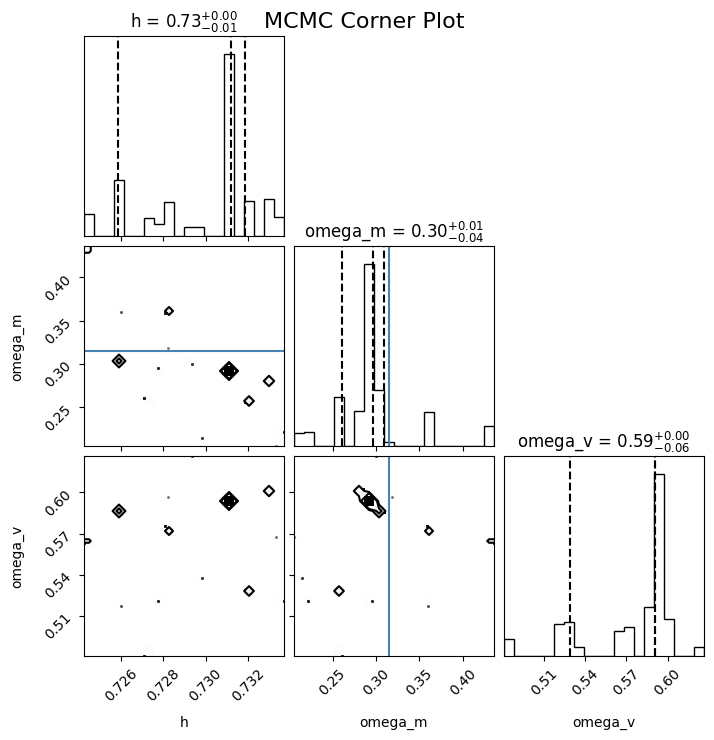

In [40]:
#plot corner plot
figure = corner.corner(samples, labels=["h", "omega_m", "omega_v"],
                       truths=[0.678, 0.315, 0.685],
                       quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 12})

figure.suptitle('MCMC Corner Plot', fontsize=16)
plt.show()

From the trace plot, the algorithm converges quickly. It also doesn't appear to get stuck in certain areas of the parameter space. Omega_v seems to converge more slowly, so a higher burn-in is required.

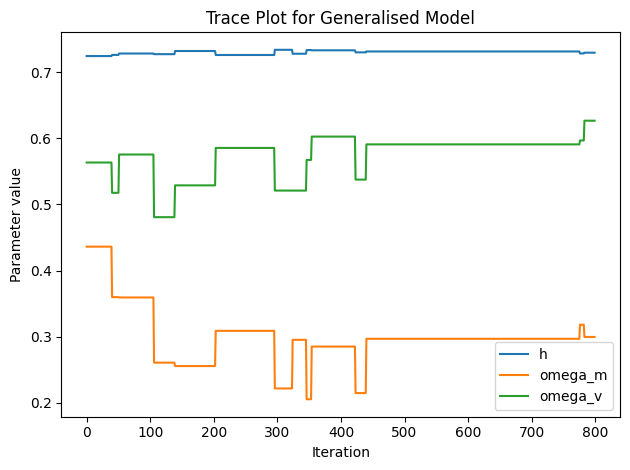

In [41]:
#plot trace plots for each parameter
plt.plot(samples[:, 0], label='h')
plt.plot(samples[:, 1], label='omega_m')
plt.plot(samples[:, 2], label='omega_v')
plt.title('Trace Plot for Generalised Model')
plt.xlabel('Iteration')
plt.ylabel('Parameter value')
plt.legend()

plt.tight_layout()
plt.show()

The means are very close to the real values, suggesting the algorithm to be accurate in determining these parameters.

In [42]:
#compute averages (means)
mean_h = np.mean(samples[:, 0])
mean_omega_m = np.mean(samples[:, 1])
mean_omega_v = np.mean(samples[:, 2])

#compute variances
var_h = np.var(samples[:, 0])
var_omega_m = np.var(samples[:, 1])
var_omega_v = np.var(samples[:, 2])

#compute covariance
cov_matrix = np.cov(samples.T)  # Transpose to get parameters as columns

#print results
print(f"Mean of h: {mean_h}, Variance of h: {var_h}")
print(f"Mean of Omega_m: {mean_omega_m}, Variance of Omega_m: {var_omega_m}")
print(f"Mean of Omega_v: {mean_omega_v}, Variance of Omega_m: {var_omega_v}")
print("Covariance Matrix:")
print(cov_matrix)

Mean of h: 0.7298956450821947, Variance of h: 6.849663806844436e-06
Mean of Omega_m: 0.2995465760730183, Variance of Omega_m: 0.0019315554200771132
Mean of Omega_v: 0.5732993328756406, Variance of Omega_m: 0.0010423920895282458
Covariance Matrix:
[[ 6.85823660e-06 -7.48909242e-05  1.56801641e-05]
 [-7.48909242e-05  1.93397289e-03  3.78377600e-04]
 [ 1.56801641e-05  3.78377600e-04  1.04369671e-03]]


### Gelman-Rubens Test
---

Tests such as Gelman-Rubens can help validate algorithms such as MCMC, ensuring their results can be trusted. In this instance Gelman-Rubens is used to ensure that the algorithm isn't biased based on the initial parameters. This works by testing various sets of initial parameters and examining the R_hat statistic.

The burn-in has also been increased due to the slow convergence of the additional parameter.

In [25]:
num_chains = 5 #number of chains

#initials parameters to be tested
initial_parameters_list = [
    [0.3, 0.8, 0.7],
    [0.9, 0.9, 0.2],
    [0.2, 0.2, 0.2],
    [0.9, 0.9, 0.9],
    [0.2, 0.7, 0.2]
]

#run MCMC multiple times and append chains
chains = []
for initial_parameters in initial_parameters_list:
    samples, acceptance_rate = metropolis_hastings(mdata_df, initial_parameters, 1000, 0.1, 300)
    chains.append(samples)

/tmp/ipykernel_37328/2328902864.py:19: RuntimeWarning: overflow encountered in exp
  p_accept = np.exp(p_delta)


In [26]:
def gelman_rubin(chains):

    num_chains = len(chains)
    num_samples = len(chains[0])

    #calculate the mean of each chain
    means = np.array([np.mean(chain, axis=0) for chain in chains])

    #calculate the variance within each chain
    within_var = np.array([np.var(chain, axis=0, ddof=1) for chain in chains])

    #mean of the means across chains
    mean_of_means = np.mean(means, axis=0)

    #variance between chains
    between_var = num_samples * np.var(means, axis=0, ddof=1)

    #R-hat
    var_est = ((num_samples - 1) / num_samples) * np.mean(within_var, axis=0) + between_var / num_samples
    R_hat = np.sqrt(var_est / np.mean(within_var, axis=0))

    return R_hat

The R_hat for h is close to 1, indicating near perfect convergence. However for the omegas, the values are slightly larger, in particular for omega_v. This indicates that they have not fully converged. This could be improved by potentially increasing the number of iterations or by refining the algorithm.

In [27]:
gelman_rubin(chains)

array([1.0131125 , 1.14127952, 1.41141215])

## Conclusion
---

MCMC is clearly a powerful tool in finding cosmological parameter values, although requires careful optimisation and consideration to ensure it is applied correctly. Many aspects of the algorithm should be considered, with the answers dependent on the context. Width for example can have a significant effect, whether it be too large or too small having a significant effect on both the confidence and the accuracy of the algorithm in its predictions. Burn-in should also be considered, which is also dependent on other parameters such as the width of the proposal distribution.

The algorithm developed effectively converges on the real values of the cosmological parameters, however it could also be optimised in many more ways. For example changing the proposal distribution could improve the acceptance rate and algorithm efficiency. When optimising an algorithm it's important to also consider bias, techniques such as Gelman-Rubens can be instrumental in ensuring the algorithm isn't making decisions heavily weighted by the initial parameters.